In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load dataset
df = pd.read_csv('mail_data.csv')  # Replace with your dataset path
data = df.where((pd.notnull(df)), '')

In [3]:
# Encoding labels
data.loc[data['Category'] == 'spam', 'Category'] = 0
data.loc[data['Category'] == 'ham', 'Category'] = 1

In [4]:
# Splitting features and labels
X = data['Message']
Y = data['Category'].astype('int')  # Convert to integers

In [5]:
# Splitting dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [6]:
# Initialize the TfidfVectorizer
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)

In [7]:
# Transform the training and test data
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [8]:
# Distribution of Spam vs. Ham
category_counts = data['Category'].value_counts()

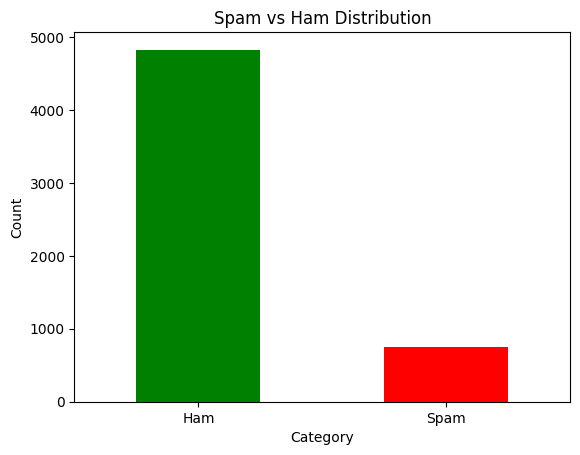

In [9]:
# Data Visualization: Spam vs. Ham Distribution
category_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Spam vs Ham Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

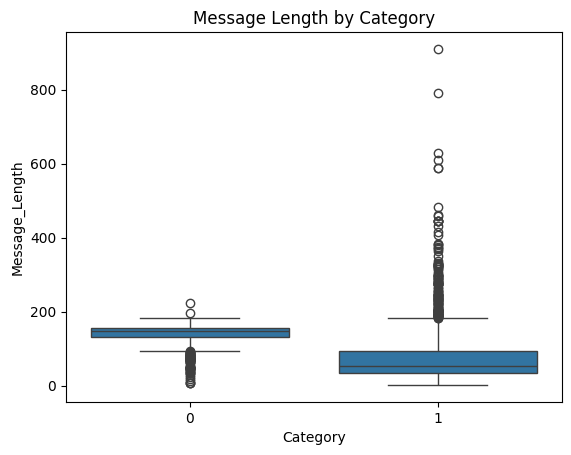

In [10]:
# Average message length by category
data['Message_Length'] = data['Message'].apply(len)
sns.boxplot(x='Category', y='Message_Length', data=data)
plt.title('Message Length by Category')
plt.show()

In [11]:
# Suppress joblib warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Replace 4 with the number of cores you want to use

# Function to evaluate multiple models
def evaluate_models(X_train_features, Y_train, X_test_features, Y_test):
    # Dictionary to store models and their names
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "XGBoost": XGBClassifier(eval_metric='logloss'),
        "LightGBM": LGBMClassifier()
    }
    
    accuracies = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_features, Y_train)
        
        # Predict on the test set
        predictions = model.predict(X_test_features)
        
        # Calculate accuracy
        accuracy = accuracy_score(Y_test, predictions)
        
        # Store accuracy in dictionary
        accuracies[model_name] = accuracy
    
    # Print accuracies
    print("Model Accuracies:")
    for model_name, accuracy in accuracies.items():
        print(f"{model_name}: {accuracy * 100:.2f}%")
    
    return accuracies

In [12]:
# Call the function and evaluate all models
model_accuracies = evaluate_models(X_train_features, Y_train, X_test_features, Y_test)

[LightGBM] [Info] Number of positive: 3865, number of negative: 592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5591
[LightGBM] [Info] Number of data points in the train set: 4457, number of used features: 320
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.867175 -> initscore=1.876210
[LightGBM] [Info] Start training from score 1.876210
Model Accuracies:
Logistic Regression: 96.68%
Random Forest: 97.76%
SVM: 97.94%
XGBoost: 97.40%
LightGBM: 97.67%


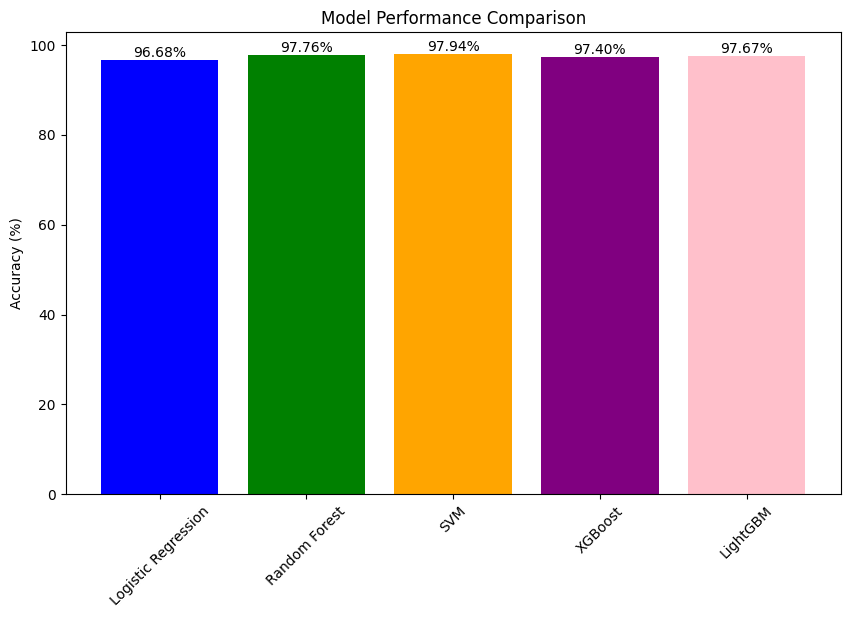

In [13]:
# Bar plot for model performance comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_accuracies.keys(), [v * 100 for v in model_accuracies.values()], color=['blue', 'green', 'orange', 'purple', 'pink'])

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# Set plot labels and title
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': [0.01, 0.1, 1, 10],          # Kernel coefficient
}

In [16]:
# Initialize the SVM model
svm = SVC()

In [17]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [18]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train_features, Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [19]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9795818171752402


In [20]:
# Test with the best model
best_svm = grid_search.best_estimator_
test_accuracy = accuracy_score(Y_test, best_svm.predict(X_test_features))
print(f"Test Accuracy with Best Parameters: {test_accuracy * 100:.2f}%")

Test Accuracy with Best Parameters: 98.30%


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
# Generate the confusion matrix
cm = confusion_matrix(Y_test, best_svm.predict(X_test_features))

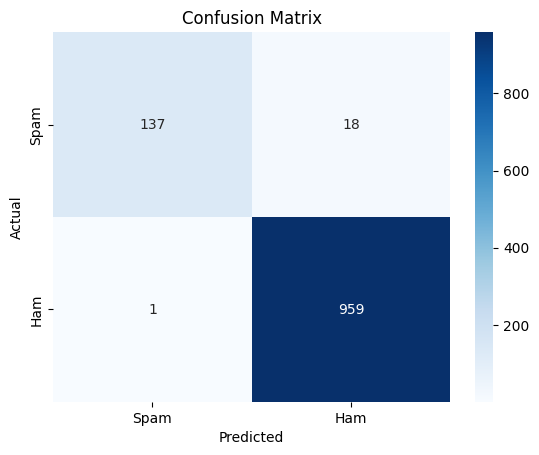

In [23]:
#Confusion Matrix: Gives a good overview of how many spam and ham emails were correctly or incorrectly classified.
# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spam', 'Ham'], yticklabels=['Spam', 'Ham'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
#Classification Report: Provides precision, recall, F1-score for each class (spam and ham), which helps in understanding model performance beyond just accuracy.
# Print classification report
print("Classification Report:")
print(classification_report(Y_test, best_svm.predict(X_test_features)))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94       155
           1       0.98      1.00      0.99       960

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [31]:
#This will allow us to load the model for future use without retraining it.
import joblib
# Save the TF-IDF vectorizer
joblib.dump(feature_extraction, 'tfidf_vectorizer.pkl')  # Save the TF-IDF vectorizer

['tfidf_vectorizer.pkl']

In [32]:
# Step 1: Save the best model
joblib.dump(best_svm, 'best_svm_model.pkl')  # Save the trained model to a file

['best_svm_model.pkl']

In [33]:
# Step 2: Load the saved model
loaded_model = joblib.load('best_svm_model.pkl')  # Load the model

In [34]:
# Step 3: Test the loaded model
loaded_model_accuracy = accuracy_score(Y_test, loaded_model.predict(X_test_features))
print(f"Test Accuracy of Loaded Model: {loaded_model_accuracy * 100:.2f}%")

Test Accuracy of Loaded Model: 98.30%


In [35]:
#Steps to Predict Spam or Ham for New Text

In [36]:
# Step 1: Load the trained model and TF-IDF vectorizer
best_svm = joblib.load('best_svm_model.pkl')  # Load the saved SVM model
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Load the trained TF-IDF vectorizer (save it the same way you saved the model)

In [37]:
# Step 2: Define the prediction function
def predict_spam_or_ham(new_email):
    # Apply the same TF-IDF transformation to the new email text
    new_email_tfidf = tfidf_vectorizer.transform([new_email])  # Transform the new email text

    # Predict using the trained SVM model
    prediction = best_svm.predict(new_email_tfidf)

    # Return the prediction result (0 = spam, 1 = ham)
    if prediction[0] == 1:
        return "Ham (Not Spam)"
    else:
        return "Spam"

In [43]:
# Step 3: Test with a new email text
new_email_text = "Congratulations! You've won a free vacation to the Bahamas. Contact us now to claim your prize!"

In [44]:
# Predict and print the result
result = predict_spam_or_ham(new_email_text)
print(f"The email is: {result}")

The email is: Spam
